# Vehicle Detection & Confirmation System
### Version 2
Summer 2023 

Created by Vikram Anantha \
Continued from Ben Dwyer's code \
July 27 2023

## Summary
(Same as V1) \
This code is meant to be implemented into Road-Side Systems (RSSs), like traffic cameras, such that it can communicate with vehicles, especially Autonomous Vehicles (AVs) to verify their identity.

### Background
(Same as V1) \
One problem that might arise when AVs communicate with RSSs is that a hacker with malicious intent can join the same channel and communicate with the RSSs as if they were the vehicle. To combat this, the RSS can command the vehicle to confirm its identity by performing a specific task. Examples of this include:
 + Displaying a specific pattern on a screen, similar to a QR code
 + Flashing headlights in a specific pattern
 + Making a sound in a specific pattern

Once the vehicle performs the task, the RSS can confirm this has been done visually, thus confirming the identiy of the vehicle. This visual confirmation, a form of Two Factor Authentication (2FA) is the premise of this code.


### Overview of Version 2

Here is an overview of the main simple code:

`while loop forever:`
 - `read in the frame from the ZED camera`
 - `detect the vehicle in the frame`
 - `process the frame:`
    - `save a cropped version of the frame of just the vehicle`
    - `greyscale the cropped image`
    - `convert the image to a binary image (any pixel above a brightness is white, any below is black); I call it "thresholding" the image`
    - `find the Mean Image Brightness (MIB)`
    - `high MIBs means brighter image, so the headlight is on, lower means dimmer means headlights off`
 - `add the on/off state to a list`


### Changes from V1

These were the shortcomings from Version 1:
 1. When using live feed, there is about a second of delay per frame to detect if a vehicle is present, and to recognize there is no bounding box. It is much more time to recognize the array in the bounding box, which needs to be done for each vehicle.
 2. The code runs a for loop to go through each vehicle and detect the pattern, meaning it verifies each vehicle one by one. Because each vehicle takes a long time to be verified, when multiple vehicles are present, the system will take a _very_ long time.
 3. When using a webcam, or a dedicated camera for the computer (as in not a smartphone camera, which uses HDR to make screens appear normal with everything else), the Arduino display is super bright, and cannot be recognized. However, this doesn't really matter as much, since in the real environment, having a screen on the windshield won't be implemented. Instead, it would most likely leverage the headlights, having them flash a pattern across time, rather than display a pattern across space.

Version 2 solves these problems in these ways:
 1. In this Version, the code only detects if there is a vehicle present, so only using 1 model instead of 2. This should cut the latency by about half. In addition, this code has the model on device, meaning it can utilize the extensive hardware to run the model faster. This cuts the latency by half again.
 2. This part isn't really fixed, since it still has to go through every vehicle to detect their pattern verification
 3. This version does not need a camera with HDR, in fact it actually leverages the HDR-less camera. When the headlights are shining, the camera overexposes them, meaning they will be much brighter than everything else. This makes it much easier to threshold the image and calculate the average brightness.

# Code and Reports
In this file, I have the code that I wrote (or borrowed), however I also inclde some mid-way reports, either what I wrote at the end of the day to get my thoughts in order, or what I sent to Dajiang at the end of the day. I kept this in to show my thought process and all the steps taken to make the final algorithm

## Pre Version 2 report

### Meeting with Dajiang Suo [Jul 24 2023]


ZED obj detection should be faster
 - https://www.stereolabs.com/docs/object-detection/
 - Detect vehicle + detect headlights + detect headlight pattern
 - ^^ simultaneously
 - Api provided by zed camera to do categorization
 - Look through https://www.stereolabs.com/docs/object-detection/custom-od/
 - To get obj detection and custom detection


Action-State Joint Learning-Based Vehicle Taillight
 - https://arxiv.org/pdf/1906.03683.pdf
 - Recognition in Diverse Actual Traffic Scenes


Document all these steps rigorouly


Another Paper
 - https://github.com/TechToker/CarLightSignalsDetection
 - ^^ sliding window of frames?


### Todo (Jul 27 2023):
 + implement Zed camera based object detection
 + run a model to use headlights as the pattern recognition
    + first get that to run on a given video
    + then write arduino code to make the display act like headlights
    + then get it to work in real time
    + then see if the pattern recognition is needed with ML or just if statements
 + try to get multiple vehicles to work fast (idk how yet)
    + zed api?
 + Priority 1: documentation

## Imports and setup

In [1]:
import glob
from roboflow import Roboflow
from ultralytics import YOLO
import time
import cv2
import numpy as np
from datetime import datetime
import os

BENS_RF_APIKEY = "2Vs9PCO5LGDCSkI0huRq"
BENS_RF_WORKSPACE = "meng-thesis-5fidi"
BENS_RF_PROJECT = "rc-vehicle-detection_v2"
ONOFF_THRES = 8
HL_THRESHOLD = 200

avg = lambda x: sum(x)/len(x)
def export_video(input_val, output_val, fps=25):
    # stich images together into video
    os.system(f"ffmpeg -y -framerate {fps} -pattern_type glob -i '{input_val}' -c:v libx264 -r 30 -pix_fmt yuv420p {output_val}")
def save_frames(image, dir):
    current_time = datetime.now().strftime("%H_%M_%S_%f")
    cv2.imwrite(dir % current_time, image)

## Zed Camera Code: Object Detection Birds Eye

In [1]:
# This code is borrowed from the ZED Camera API, which has this and many more codes here
# https://github.com/stereolabs/zed-sdk/tree/master/tutorials/tutorial%206%20-%20object%20detection/python


########################################################################
#
# Copyright (c) 2022, STEREOLABS.
#
# All rights reserved.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS
# "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT
# LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR
# A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT
# OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL,
# SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT
# LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE,
# DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY
# THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
# (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
#
########################################################################

"""
    This sample demonstrates how to capture 3D point cloud and detected objects
    with the ZED SDK and display the result in an OpenGL window.
"""

import sys
import numpy as np
import cv2
import pyzed.sl as sl
# import helpercode.ogl_viewer.viewer as gl
import helpercode.cv_viewer.tracking_viewer as cv_viewer
from helpercode.batch_system_handler import *
# because these files are in some random folder, I copied the important ones into the directory `helpercode`


##
# Variable to enable/disable the batch option in Object Detection module
# Batching system allows to reconstruct trajectories from the object detection module by adding Re-Identification / Appareance matching.
# For example, if an object is not seen during some time, it can be re-ID to a previous ID if the matching score is high enough
# Use with caution if image retention is activated (See batch_system_handler.py) :
#   --> Images will only appear if an object is detected since the batching system is based on OD detection.
USE_BATCHING = False

# if __name__ == "__main__":
if True:
    print("Running object detection ... Press 'Esc' to quit")
    zed = sl.Camera()
    
    # Create a InitParameters object and set configuration parameters
    init_params = sl.InitParameters()
    init_params.coordinate_units = sl.UNIT.METER
    init_params.coordinate_system = sl.COORDINATE_SYSTEM.RIGHT_HANDED_Y_UP  
    init_params.depth_mode = sl.DEPTH_MODE.ULTRA
    init_params.depth_maximum_distance = 20
    is_playback = False                             # Defines if an SVO is used
        
    # If applicable, use the SVO given as parameter
    # Otherwise use ZED live stream
    if len(sys.argv) == 2:
        filepath = sys.argv[1]
        print("Using SVO file: {0}".format(filepath))
        init_params.svo_real_time_mode = True
        init_params.set_from_svo_file(filepath)
        is_playback = True

    status = zed.open(init_params)
    if status != sl.ERROR_CODE.SUCCESS:
        print(repr(status))
        exit()


    # Enable positional tracking module
    positional_tracking_parameters = sl.PositionalTrackingParameters()
    # If the camera is static in space, enabling this setting below provides better depth quality and faster computation
    positional_tracking_parameters.set_as_static = True
    zed.enable_positional_tracking(positional_tracking_parameters)

    # Enable object detection module
    batch_parameters = sl.BatchParameters()
    if USE_BATCHING:
        batch_parameters.enable = True
        batch_parameters.latency = 2.0
        batch_handler = BatchSystemHandler(batch_parameters.latency*2)
    else:
        batch_parameters.enable = False
    obj_param = sl.ObjectDetectionParameters(batch_trajectories_parameters=batch_parameters)
        
    obj_param.detection_model = sl.OBJECT_DETECTION_MODEL.MULTI_CLASS_BOX_FAST
    # Defines if the object detection will track objects across images flow.
    obj_param.enable_tracking = True
    zed.enable_object_detection(obj_param)

    camera_infos = zed.get_camera_information()
    # Create OpenGL viewer
    # viewer = gl.GLViewer()
    point_cloud_res = sl.Resolution(min(camera_infos.camera_configuration.resolution.width, 720), min(camera_infos.camera_configuration.resolution.height, 404)) 
    point_cloud_render = sl.Mat()
    # viewer.init(camera_infos.camera_model, point_cloud_res, obj_param.enable_tracking)
    
    # Configure object detection runtime parameters
    obj_runtime_param = sl.ObjectDetectionRuntimeParameters()
    detection_confidence = 60
    obj_runtime_param.detection_confidence_threshold = detection_confidence
    # To select a set of specific object classes
    obj_runtime_param.object_class_filter = [sl.OBJECT_CLASS.PERSON]
    # To set a specific threshold
    obj_runtime_param.object_class_detection_confidence_threshold = {sl.OBJECT_CLASS.PERSON: detection_confidence} 

    # Runtime parameters
    runtime_params = sl.RuntimeParameters()
    runtime_params.confidence_threshold = 50

    # Create objects that will store SDK outputs
    point_cloud = sl.Mat(point_cloud_res.width, point_cloud_res.height, sl.MAT_TYPE.F32_C4, sl.MEM.CPU)
    objects = sl.Objects()
    image_left = sl.Mat()

    # Utilities for 2D display
    display_resolution = sl.Resolution(min(camera_infos.camera_configuration.resolution.width, 1280), min(camera_infos.camera_configuration.resolution.height, 720))
    image_scale = [display_resolution.width / camera_infos.camera_configuration.resolution.width
                 , display_resolution.height / camera_infos.camera_configuration.resolution.height]
    image_left_ocv = np.full((display_resolution.height, display_resolution.width, 4), [245, 239, 239,255], np.uint8)

    # Utilities for tracks view
    camera_config = zed.get_camera_information().camera_configuration
    tracks_resolution = sl.Resolution(400, display_resolution.height)
    track_view_generator = cv_viewer.TrackingViewer(tracks_resolution, camera_config.fps, init_params.depth_maximum_distance)
    track_view_generator.set_camera_calibration(camera_config.calibration_parameters)
    image_track_ocv = np.zeros((tracks_resolution.height, tracks_resolution.width, 4), np.uint8)

    # Will store the 2D image and tracklet views 
    global_image = np.full((display_resolution.height, display_resolution.width+tracks_resolution.width, 4), [245, 239, 239,255], np.uint8)

    # Camera pose
    cam_w_pose = sl.Pose()
    cam_c_pose = sl.Pose()

    quit_app = False

    # while(viewer.is_available() and (quit_app == False)):
    while((quit_app == False)):
        if zed.grab(runtime_params) == sl.ERROR_CODE.SUCCESS:
            # Retrieve objects
            returned_state = zed.retrieve_objects(objects, obj_runtime_param)
            
            if (returned_state == sl.ERROR_CODE.SUCCESS and objects.is_new):
                # Retrieve point cloud
                zed.retrieve_measure(point_cloud, sl.MEASURE.XYZRGBA,sl.MEM.CPU, point_cloud_res)
                point_cloud.copy_to(point_cloud_render)
                # Retrieve image
                zed.retrieve_image(image_left, sl.VIEW.LEFT, sl.MEM.CPU, display_resolution)
                image_render_left = image_left.get_data()
                # Get camera pose
                zed.get_position(cam_w_pose, sl.REFERENCE_FRAME.WORLD)

                update_render_view = True
                # update_3d_view = True
                update_tracking_view = True

                if USE_BATCHING:
                    zed.get_position(cam_c_pose, sl.REFERENCE_FRAME.CAMERA)
                    objects_batch = []
                    zed.get_objects_batch(objects_batch)
                    batch_handler.push(cam_c_pose,cam_w_pose,image_left,point_cloud,objects_batch)
                    cam_c_pose, cam_w_pose, image_left, point_cloud_render, objects = batch_handler.pop(cam_c_pose,cam_w_pose,image_left,point_cloud,objects)
                    
                    image_render_left = image_left.get_data()
                    
                    update_tracking_view = objects.is_new

                    if WITH_IMAGE_RETENTION:
                        update_render_view = objects.is_new
                        # update_3d_view = objects.is_new
                    else:
                        update_render_view = True
                        # update_3d_view = True

                # 3D rendering
                # if update_3d_view:
                    # viewer.updateData(point_cloud_render, objects)

                # 2D rendering
                if update_render_view:
                    np.copyto(image_left_ocv,image_render_left)
                    cv_viewer.render_2D(image_left_ocv,image_scale,objects, obj_param.enable_tracking)
                    global_image = cv2.hconcat([image_left_ocv,image_track_ocv])

                # Tracking view
                if update_tracking_view:
                    track_view_generator.generate_view(objects, cam_w_pose, image_track_ocv, objects.is_tracked)
                    
            cv2.imshow("ZED | 2D View and Birds View",global_image)
            cv2.waitKey(10)

        if (is_playback and (zed.get_svo_position() == zed.get_svo_number_of_frames()-1)):
            print("End of SVO")
            quit_app = True


    cv2.destroyAllWindows()
    # viewer.exit()
    image_left.free(sl.MEM.CPU)
    point_cloud.free(sl.MEM.CPU)
    point_cloud_render.free(sl.MEM.CPU)

    if USE_BATCHING:
        batch_handler.clear()

    # Disable modules and close camera
    zed.disable_object_detection()
    zed.disable_positional_tracking()

    zed.close()

Running object detection ... Press 'Esc' to quit


KeyboardInterrupt: 

## About RoboFlow and Yolo

[Roboflow](https://roboflow.com/) is a platform which houses a vast variety of models, mainly for computer vision. It is often used because it is easy to train the models, and prediction happens over the cloud. For computer vision, Roboflow uses [YOLOv8](https://blog.roboflow.com/whats-new-in-yolov8/) (You Only Look Once), the fastest and most accurate architecture.

Roboflow has a very intuitive process to upload training images and annotate them. For models that detect (rather than just classify), the model not only must be given the image, but also the coordinates on the image of where the object in question is, and what the object is called. Roboflow allows you to create the training data fairly easily, and can then be downloaded to be trained on device.

In Version 1, the training data and the models was stored on RoboFlow, meaning anytime the code required a prediction from the model, it would make a call through the internet. This is ideal for most cases, (i.e. if the user is using a Windows laptop from 1997), however the RSS is meant to be run on an Edge computer, meaning it should have the capabilities to run the model on device. In this version, the model is trained and run on device, making it much faster.

To do this, the dataset created in RoboFlow is downloaded onto the device, and a YoloV8 model is trained with this dataset.

When the dataset is downloaded, it is stored in a folder (for example, `RC-Vehicle-Detection_v2-1`), which has some stuff
 - `test/`
    - `images/`
        - folder of the unedited images that were uploaded
    - `labels/`
        - txt files with the coords of where the object is and its classification
 - `train/`
    - same subfolders as `test`
 - `valid/`
    - same subfolders as `test`
 - `data.yaml`
    - the main datafile, has info about where the images are, what the clssifications are, etc. This file is the only file inputted when training the model 
 - `README`s

The model is then trained with this data, and saved.

## Training the Models

In [2]:
# To Download the Dataset from Ben's RoboFlow project

# !pip install roboflow
# ^^ Don't run this line if it's already installed

rf = Roboflow(api_key=BENS_RF_APIKEY)
project = rf.workspace(BENS_RF_WORKSPACE).project(BENS_RF_PROJECT)
dataset = project.version(1).download("yolov8")


loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics<=8.0.20 is required but found version=8.0.143, to fix: `pip install ultralytics<=8.0.20`


Extracting Dataset Version Zip to RC-Vehicle-Detection_v2-1 in yolov8:: 100%|██████████| 1658/1658 [00:14<00:00, 116.71it/s] 


In [ ]:
## Training a custom detector

# based on this tutorial: https://learnopencv.com/train-yolov8-on-custom-dataset/

# Load the model.
model = YOLO('yolov8m.pt')
 
# # Training.
results = model.train(
   data=f'{dataset.location}/data.yaml',
   imgsz=1280,
   epochs=100,
   batch=8,
   name='yolov8m_rc_v2'
)

# For nano model, epochs 100, imgsize 640, it took 769 mins to train


In [3]:
model = YOLO('yolov8s.pt')
 
# # Training.
results = model.train(
   data=f'{dataset.location}/data.yaml',
   # data = 'RC-Vehicle-Detection_v2-1/data.yaml',
   imgsz=640,
   epochs=100,
   batch=8,
   name='yolov8s_rc_v3'
)

# If a model ever gets interrupted in training, you can continue it by doing

# model = YOLO('runs/detect/yolov8m_rc_v2/weights/last.pt')
# model.train(resume=True)

New https://pypi.org/project/ultralytics/8.0.151 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.143 🚀 Python-3.8.10 torch-2.0.0 CPU (ARMv8 Processor rev 1 (v8l))
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/home/auto-id/Vikram Anantha Summer 2023/Codes/RC-Vehicle-Detection_v2-1/data.yaml, epochs=100, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8s_rc_v3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visu

In [2]:
# Resuming interrupted model
# Weekend of Aug 3 it took 6800 mins
# Aug 7 night      it took 1232 mins
# Aug 10 weekend   it took 1712 mins

model = YOLO('runs/detect/yolov8m_rc_v2/weights/last.pt')

model.train(resume=True)

New https://pypi.org/project/ultralytics/8.0.150 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.143 🚀 Python-3.8.10 torch-2.0.0 CPU (ARMv8 Processor rev 1 (v8l))
engine/trainer: task=detect, mode=train, model=runs/detect/yolov8m_rc_v2/weights/last.pt, data=/home/auto-id/Vikram Anantha Summer 2023/Codes/RC-Vehicle-Detection_v2-1/data.yaml, epochs=100, patience=50, batch=8, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=0, project=None, name=yolov8m_rc_v2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid

## Model Results


The default YOLOv8 model is the nano model, which is said to be the smallest and is therefore the fastest. However, there are 2 other models that we can use: YOLOv8s (small) and YOLOv8m (medium). These models are bigger, so in theory should be more accurate but might take longer.

Here is how each model performed:


Training
| Model Size | Epochs | Image Size | Training Time | Code Name |
| --- | --- | --- | --- | --- |
| Nano | 100 | 640 | 769 mins (12.8 hrs) | Nano 100x640 |
| Medium | 71 | 1280 | 6800 mins (4.7 days) | Med 71x1280 |
| Medium | 100 | 1280 | 9744 mins (6.8 days) | Med 100x1280 |

Testing
| Model Size | Image Source | Time per Image | Accuracy |
| --- | --- | --- | --- |
| Nano 100x640 | Photo from Ben's phone   | 0.1s | ~85% |
| Nano 100x640 | Video from my phone   | 0.3s | ~85% |
| Nano 100x640 | Frame from ZED Camera | 0.5s | ~80% |
| Med 100x1280 | Photo from Ben's phone | 0.7s | 87% |

## Testing the Models

#### Loading the new model

In [2]:
# model = YOLO('runs/detect/yolov8n_rc_v13/weights/best.pt')
model = YOLO('runs/detect/yolov8s_rc_v3/weights/best.pt')
# metrics = model.val()
# metrics.box.map

#### Trying it on the test images

In [3]:
results = model(glob.glob('RC-Vehicle-Detection_v2-1/test/images/*.jpg'),
                save=True,
                save_txt=True,
                save_conf=True,
                save_crop=True,
                )
# Nano: Takes 3.6 seconds to predict on 35 images, so about 0.1s per image.
# Small: Takes 9.5 seconds to predict on 35 images, so about 0.27s per image
# Medium: 50s to predict 35 images, 1.4s per image




0: 448x640 1 RC-Car, 1: 448x640 1 RC-Car, 2: 448x640 1 RC-Car, 3: 448x640 1 RC-Car, 4: 448x640 1 RC-Car, 5: 448x640 1 RC-Car, 6: 448x640 1 RC-Car, 7: 448x640 1 RC-Car, 8: 448x640 1 RC-Car, 9: 448x640 1 RC-Car, 10: 448x640 1 RC-Car, 11: 448x640 1 RC-Car, 12: 448x640 1 RC-Car, 13: 448x640 1 RC-Car, 14: 448x640 1 RC-Car, 15: 448x640 1 RC-Car, 16: 448x640 1 RC-Car, 17: 448x640 1 RC-Car, 18: 448x640 1 RC-Car, 19: 448x640 1 RC-Car, 20: 448x640 1 RC-Car, 21: 448x640 1 RC-Car, 22: 448x640 1 RC-Car, 23: 448x640 1 RC-Car, 24: 448x640 1 RC-Car, 25: 448x640 1 RC-Car, 26: 448x640 1 RC-Car, 27: 448x640 1 RC-Car, 28: 448x640 1 RC-Car, 29: 448x640 1 RC-Car, 30: 448x640 1 RC-Car, 31: 448x640 1 RC-Car, 32: 448x640 1 RC-Car, 33: 448x640 1 RC-Car, 34: 448x640 1 RC-Car, 6196.7ms
Speed: 3.6ms preprocess, 177.0ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict15
35 labels saved to runs/detect/predict15/labels


#### Making my own score function for the model

In [9]:

def score(realdata_path, fakedata_path):
    
    realdata_files = glob.glob(realdata_path)
    fakedata_files = glob.glob(fakedata_path)
    if (len(realdata_files) != len(fakedata_files)):
        raise "WrongFilePathException"
    confs = []
    bounds_diffs = []
    for i in range(len(realdata_files)):
        with open(realdata_files[i], 'r') as rfile:
            robj, rxl, rxr, ryl, ryr = map(float, rfile.readline().split(" "))
        with open(fakedata_files[i], 'r') as ffile:
            fobj, fxl, fxr, fyl, fyr, fconf = map(float, ffile.readline().split(" "))
            
        confs.append(fconf)
        bounds_diffs.append(abs(rxl-fxl)*100)
        bounds_diffs.append(abs(rxr-fxr)*100)
        bounds_diffs.append(abs(ryl-fyl)*100)
        bounds_diffs.append(abs(ryr-fyr)*100)
        
    print("Average Confidence:             ", avg(confs))
    print("Average Bounding Box Difference:", avg(bounds_diffs), "% of the image")

score(
    realdata_path='RC-Vehicle-Detection_v2-1/test/labels/*.txt',
    fakedata_path = 'runs/detect/predict14/labels/BEN_*.txt'
)

Average Confidence:              0.8737912857142859
Average Bounding Box Difference: 0.6660827142857139 % of the image


#### Trying the model on a video

In [10]:
model("Videos/drive_05/drive_05_vikram2023.mp4",
      save=True,
      save_txt=True,
      save_conf=True,
      save_crop=True
)

# 15.5s video, with save,save_txt,save_conf,save_crop:
# 
# 160 seconds to predict
# 1/3 seconds to predict per frame



    WARNING ⚠️ stream/video/webcam/dir predict source will accumulate results in RAM unless `stream=True` is passed,
    causing potential out-of-memory errors for large sources or long-running streams/videos.

    Usage:
        results = model(source=..., stream=True)  # generator of Results objects
        for r in results:
            boxes = r.boxes  # Boxes object for bbox outputs
            masks = r.masks  # Masks object for segment masks outputs
            probs = r.probs  # Class probabilities for classification outputs

video 1/1 (1/453) /home/auto-id/Vikram Anantha Summer 2023/Codes/Videos/drive_05/drive_05_vikram2023.mp4: 736x1280 1 RC-Car, 1839.2ms
video 1/1 (2/453) /home/auto-id/Vikram Anantha Summer 2023/Codes/Videos/drive_05/drive_05_vikram2023.mp4: 736x1280 1 RC-Car, 1867.5ms
video 1/1 (3/453) /home/auto-id/Vikram Anantha Summer 2023/Codes/Videos/drive_05/drive_05_vikram2023.mp4: 736x1280 1 RC-Car, 1845.2ms
video 1/1 (4/453) /home/auto-id/Vikram Anantha Summer 202

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 keys: ['boxes']
 masks: None
 names: {0: 'RC-Car'}
 orig_img: array([[[ 55,  60,  46],
         [ 55,  60,  46],
         [ 55,  60,  46],
         ...,
         [101, 104, 105],
         [101, 104, 105],
         [101, 104, 105]],
 
        [[ 55,  60,  46],
         [ 55,  60,  46],
         [ 55,  60,  46],
         ...,
         [101, 104, 105],
         [101, 104, 105],
         [101, 104, 105]],
 
        [[ 55,  60,  46],
         [ 55,  60,  46],
         [ 55,  60,  46],
         ...,
         [101, 104, 105],
         [101, 104, 105],
         [101, 104, 105]],
 
        ...,
 
        [[154, 180, 193],
         [164, 189, 202],
         [124, 150, 162],
         ...,
         [122, 125, 122],
         [113, 117, 113],
         [134, 138, 134]],
 
        [[175, 201, 214],
         [150, 175, 188],
         [122, 147, 160],
         ...,
         [12

#### Using CV2 to detect RCC with on device model

In [ ]:
def cv2_livefeed_rfdevice(foldername = 'runs/detect/predict10/'):
  
    # define a video capture object
    vid = cv2.VideoCapture(-1) # use the camera
    vid.set(cv2.CAP_PROP_FRAME_WIDTH, 3840) 
    vid.set(cv2.CAP_PROP_FRAME_HEIGHT, 2160)
    # 4k dimensions
    
    
    filename = foldername + 'image0.jpg'
    # Where it saves the frame
    
    latencies = [] # For understanding later

    while(True):

        # Capture the video frame by frame
        
        for _ in range(4): 
            vid.grab()
        # for some reason cv2 takes the next 5 frames and buffers them
        # this means that whats displayed is 5 frames behind
        # but when each frame takes a second to process, that's a 5 second delay
        # this makes sure its only looking at the current frame
        
        
        ret, frame = vid.read() # getting the frame
        startbig = time.time() # to calculate the latency
        
        # Zed cameras have two cameras so only use one of them
        frame = np.hsplit(frame, 2)[0]
        
        
        # do vehicle detection
        model(
            frame, 
            save=True, 
            verbose=False
        )
        # The model can save the image, but does so in some random place
        
        # display frame
        boxedframe = cv2.imread(filename)
        endbig = time.time()
        cv2.imshow('frame', boxedframe)
        
        # print(f"{round(endbig-startbig, 2)} seconds overall")
        latencies.append(endbig-startbig)
        
        
        # the 'q' button is set as the
        # quitting button you may use any
        # desired button of your choice
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
        
        save_frames(
            image=frame,
            dir = foldername + 'video_frames/frame_%s.jpg'
        )
        # To save the frames if you want to make a video

    # After the loop release the cap object
    vid.release()
    # Destroy all the windows
    cv2.destroyAllWindows()
    
    print("Average Latency: ", round(avg(latencies), 3), "seconds")
    
    # Turn the frames into a video
    export_video(
        input_val=foldername + 'video_frames/frame_*.jpg',
        fps=4,
        output_val=foldername + 'in_the_sun.mp4'
    )
    
cv2_livefeed_rfdevice(
    foldername = 'runs/detect/predict10/' 
)
# ~0.52 seconds per loop
# ~0.42 seconds of latency

#### Using ZED camera tracking code with custom detection to recognize the vehicle

In [1]:
# This code uses ZED Camera's code
# The benefit of this is that it uses the 2 cameras to create a 3D map
# This means it can detect the distance of the object, and it can track it across the space
# However its a bit hard to modify this code

#!/usr/bin/env python3

import sys
import numpy as np

import argparse
import torch
import cv2
import pyzed.sl as sl
from ultralytics import YOLO

from threading import Lock, Thread
from time import sleep
import time

import glob
from roboflow import Roboflow
from ultralytics import YOLO
import time
import cv2
import numpy as np

avg = lambda x: sum(x)/len(x)

# import helpercode.custom.ogl_viewer.viewer as gl
import helpercode.cv_viewer.tracking_viewer as cv_viewer
# from helpercode.batch_system_handler import *

lock = Lock()
run_signal = False
exit_signal = False


def xywh2abcd(xywh, im_shape):
    output = np.zeros((4, 2))

    # Center / Width / Height -> BBox corners coordinates
    x_min = (xywh[0] - 0.5*xywh[2]) #* im_shape[1]
    x_max = (xywh[0] + 0.5*xywh[2]) #* im_shape[1]
    y_min = (xywh[1] - 0.5*xywh[3]) #* im_shape[0]
    y_max = (xywh[1] + 0.5*xywh[3]) #* im_shape[0]

    # A ------ B
    # | Object |
    # D ------ C

    output[0][0] = x_min
    output[0][1] = y_min

    output[1][0] = x_max
    output[1][1] = y_min

    output[2][0] = x_min
    output[2][1] = y_max

    output[3][0] = x_max
    output[3][1] = y_max
    return output

def detections_to_custom_box(detections, im0):
    output = []
    for i, det in enumerate(detections):
        xywh = det.xywh[0]

        # Creating ingestable objects for the ZED SDK
        obj = sl.CustomBoxObjectData()
        obj.bounding_box_2d = xywh2abcd(xywh, im0.shape)
        obj.label = det.cls
        obj.probability = det.conf
        obj.is_grounded = False
        output.append(obj)
    return output


def torch_thread(weights, img_size, conf_thres=0.2, iou_thres=0.45):
    global image_net, exit_signal, run_signal, detections

    print("Intializing Network...")

    model = YOLO(weights)

    while not exit_signal:
        if run_signal:
            lock.acquire()

            img = cv2.cvtColor(image_net, cv2.COLOR_BGRA2RGB)
            # https://docs.ultralytics.com/modes/predict/#video-suffixes
            det = model.predict(img, save=False, imgsz=img_size, conf=conf_thres, iou=iou_thres)[0].cpu().numpy().boxes

            # ZED CustomBox format (with inverse letterboxing tf applied)
            detections = detections_to_custom_box(det, image_net)
            lock.release()
            run_signal = False
        sleep(0.01)


def main():
    global image_net, exit_signal, run_signal, detections
    weights = "runs/detect/yolov8n_rc_v13/weights/best.pt"
    img_size = 416
    conf_thres=0.4
    svo = None
    capture_thread = Thread(target=torch_thread, kwargs={
        'weights': weights, 
        'img_size': img_size, 
        "conf_thres": conf_thres
    })
    capture_thread.start()
    
    latencies = []

    print("Initializing Camera...")

    zed = sl.Camera()

    input_type = sl.InputType()
    if svo is not None:
        input_type.set_from_svo_file(svo)

    # Create a InitParameters object and set configuration parameters
    init_params = sl.InitParameters(input_t=input_type, svo_real_time_mode=True)
    init_params.coordinate_units = sl.UNIT.METER
    init_params.depth_mode = sl.DEPTH_MODE.ULTRA  # QUALITY
    init_params.coordinate_system = sl.COORDINATE_SYSTEM.RIGHT_HANDED_Y_UP
    init_params.depth_maximum_distance = 50

    runtime_params = sl.RuntimeParameters()
    status = zed.open(init_params)

    if status != sl.ERROR_CODE.SUCCESS:
        print(repr(status))
        exit()

    image_left_tmp = sl.Mat()

    print("Initialized Camera")

    positional_tracking_parameters = sl.PositionalTrackingParameters()
    # If the camera is static, uncomment the following line to have better performances and boxes sticked to the ground.
    # positional_tracking_parameters.set_as_static = True
    zed.enable_positional_tracking(positional_tracking_parameters)

    obj_param = sl.ObjectDetectionParameters()
    obj_param.detection_model = sl.OBJECT_DETECTION_MODEL.CUSTOM_BOX_OBJECTS
    obj_param.enable_tracking = True
    zed.enable_object_detection(obj_param)

    objects = sl.Objects()
    obj_runtime_param = sl.ObjectDetectionRuntimeParameters()

    # Display
    camera_infos = zed.get_camera_information()
    camera_res = camera_infos.camera_configuration.resolution
    # Create OpenGL viewer
    # viewer = gl.GLViewer()
    point_cloud_res = sl.Resolution(min(camera_res.width, 720), min(camera_res.height, 404))
    point_cloud_render = sl.Mat()
    # viewer.init(camera_infos.camera_model, point_cloud_res, obj_param.enable_tracking)
    point_cloud = sl.Mat(point_cloud_res.width, point_cloud_res.height, sl.MAT_TYPE.F32_C4, sl.MEM.CPU)
    image_left = sl.Mat()
    # Utilities for 2D display
    display_resolution = sl.Resolution(min(camera_res.width, 1280), min(camera_res.height, 720))
    image_scale = [display_resolution.width / camera_res.width, display_resolution.height / camera_res.height]
    image_left_ocv = np.full((display_resolution.height, display_resolution.width, 4), [245, 239, 239, 255], np.uint8)

    # Utilities for tracks view
    camera_config = camera_infos.camera_configuration
    tracks_resolution = sl.Resolution(400, display_resolution.height)
    track_view_generator = cv_viewer.TrackingViewer(tracks_resolution, camera_config.fps, init_params.depth_maximum_distance)
    track_view_generator.set_camera_calibration(camera_config.calibration_parameters)
    image_track_ocv = np.zeros((tracks_resolution.height, tracks_resolution.width, 4), np.uint8)
    # Camera pose
    cam_w_pose = sl.Pose()

    # while viewer.is_available() and not exit_signal:
    while not exit_signal:
        if zed.grab(runtime_params) == sl.ERROR_CODE.SUCCESS:
            # -- Get the image
            
            lock.acquire()
            zed.retrieve_image(image_left_tmp, sl.VIEW.LEFT)
            
            image_net = image_left_tmp.get_data()
            lock.release()
            run_signal = True
            startbig = time.time()

            # -- Detection running on the other thread
            while run_signal:
                sleep(0.001)

            # Wait for detections
            lock.acquire()
            # -- Ingest detections
            zed.ingest_custom_box_objects(detections)
            lock.release()
            zed.retrieve_objects(objects, obj_runtime_param)

            # -- Display
            # Retrieve display data
            zed.retrieve_measure(point_cloud, sl.MEASURE.XYZRGBA, sl.MEM.CPU, point_cloud_res)
            point_cloud.copy_to(point_cloud_render)
            zed.retrieve_image(image_left, sl.VIEW.LEFT, sl.MEM.CPU, display_resolution)
            zed.get_position(cam_w_pose, sl.REFERENCE_FRAME.WORLD)

            # 3D rendering
            # viewer.updateData(point_cloud_render, objects)
            # 2D rendering
            np.copyto(image_left_ocv, image_left.get_data())
            cv_viewer.render_2D(image_left_ocv, image_scale, objects, obj_param.enable_tracking)
            global_image = cv2.hconcat([image_left_ocv, image_track_ocv])
            # Tracking view
            track_view_generator.generate_view(objects, cam_w_pose, image_track_ocv, objects.is_tracked)
            endbig = time.time()
            cv2.imshow("ZED | 2D View and Birds View", global_image)
            key = cv2.waitKey(10)
            if key == 27:
                exit_signal = True
                
            
            print(round(endbig-startbig, 2), "seconds")
            latencies.append(endbig-startbig)
        else:
            exit_signal = True

    # viewer.exit()
    exit_signal = True
    zed.close()
    
    print(round(avg(latencies), 3), "seconds per loop")




with torch.no_grad():
    main()
    
# 0.605 seconds per loop
# 0.605 seconds of latency


# in hallway, max distance = 4.3 meters
# 0.68 seconds per loop

# in outside, 5.6 max partly cloudy
# 80% outside partly cloudy


Intializing Network...Initializing Camera...

Initialized Camera



0: 256x416 1 RC-Car, 726.4ms
Speed: 3.9ms preprocess, 726.4ms inference, 2.5ms postprocess per image at shape (1, 3, 256, 416)



2.87 seconds


0: 256x416 (no detections), 802.9ms
Speed: 3.3ms preprocess, 802.9ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.84 seconds


0: 256x416 (no detections), 660.5ms
Speed: 3.0ms preprocess, 660.5ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.7 seconds


0: 256x416 (no detections), 600.8ms
Speed: 3.2ms preprocess, 600.8ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.63 seconds


0: 256x416 (no detections), 697.1ms
Speed: 3.2ms preprocess, 697.1ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.73 seconds


0: 256x416 (no detections), 744.0ms
Speed: 3.4ms preprocess, 744.0ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.77 seconds


0: 256x416 (no detections), 840.7ms
Speed: 3.3ms preprocess, 840.7ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 416)



0.87 seconds


0: 256x416 (no detections), 591.9ms
Speed: 3.0ms preprocess, 591.9ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.62 seconds


0: 256x416 (no detections), 411.5ms
Speed: 3.0ms preprocess, 411.5ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.44 seconds


0: 256x416 (no detections), 506.9ms
Speed: 2.9ms preprocess, 506.9ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 416)



0.53 seconds


0: 256x416 (no detections), 707.9ms
Speed: 3.4ms preprocess, 707.9ms inference, 3.8ms postprocess per image at shape (1, 3, 256, 416)



0.75 seconds


0: 256x416 (no detections), 633.2ms
Speed: 2.8ms preprocess, 633.2ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.67 seconds


0: 256x416 (no detections), 474.9ms
Speed: 3.2ms preprocess, 474.9ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.5 seconds


0: 256x416 (no detections), 858.8ms
Speed: 4.4ms preprocess, 858.8ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.9 seconds


0: 256x416 (no detections), 731.6ms
Speed: 3.7ms preprocess, 731.6ms inference, 4.2ms postprocess per image at shape (1, 3, 256, 416)



0.77 seconds


0: 256x416 (no detections), 526.1ms
Speed: 3.0ms preprocess, 526.1ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.56 seconds


0: 256x416 (no detections), 670.3ms
Speed: 2.8ms preprocess, 670.3ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.7 seconds


0: 256x416 (no detections), 447.3ms
Speed: 3.0ms preprocess, 447.3ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.48 seconds


0: 256x416 (no detections), 606.7ms
Speed: 3.2ms preprocess, 606.7ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.64 seconds


0: 256x416 (no detections), 632.1ms
Speed: 2.9ms preprocess, 632.1ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.67 seconds


0: 256x416 (no detections), 602.8ms
Speed: 4.1ms preprocess, 602.8ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.63 seconds


0: 256x416 (no detections), 313.8ms
Speed: 2.9ms preprocess, 313.8ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.34 seconds


0: 256x416 (no detections), 558.1ms
Speed: 2.8ms preprocess, 558.1ms inference, 4.4ms postprocess per image at shape (1, 3, 256, 416)



0.59 seconds


0: 256x416 (no detections), 427.9ms
Speed: 3.3ms preprocess, 427.9ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.46 seconds


0: 256x416 (no detections), 376.4ms
Speed: 3.2ms preprocess, 376.4ms inference, 4.1ms postprocess per image at shape (1, 3, 256, 416)



0.41 seconds


0: 256x416 (no detections), 411.8ms
Speed: 2.7ms preprocess, 411.8ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.44 seconds


0: 256x416 (no detections), 421.5ms
Speed: 3.8ms preprocess, 421.5ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.46 seconds


0: 256x416 (no detections), 637.6ms
Speed: 3.2ms preprocess, 637.6ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 416)



0.66 seconds


0: 256x416 (no detections), 391.3ms
Speed: 3.1ms preprocess, 391.3ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.43 seconds


0: 256x416 (no detections), 515.1ms
Speed: 3.2ms preprocess, 515.1ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.55 seconds


0: 256x416 (no detections), 355.2ms
Speed: 4.0ms preprocess, 355.2ms inference, 4.4ms postprocess per image at shape (1, 3, 256, 416)



0.39 seconds


0: 256x416 (no detections), 434.0ms
Speed: 3.1ms preprocess, 434.0ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.46 seconds


0: 256x416 (no detections), 401.7ms
Speed: 2.8ms preprocess, 401.7ms inference, 4.2ms postprocess per image at shape (1, 3, 256, 416)



0.44 seconds


0: 256x416 (no detections), 410.1ms
Speed: 2.9ms preprocess, 410.1ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.44 seconds


0: 256x416 (no detections), 616.3ms
Speed: 2.8ms preprocess, 616.3ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.64 seconds


0: 256x416 (no detections), 550.1ms
Speed: 3.0ms preprocess, 550.1ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 416)



0.58 seconds


0: 256x416 (no detections), 459.8ms
Speed: 3.1ms preprocess, 459.8ms inference, 4.1ms postprocess per image at shape (1, 3, 256, 416)



0.5 seconds


0: 256x416 (no detections), 422.4ms
Speed: 3.2ms preprocess, 422.4ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.46 seconds


0: 256x416 1 RC-Car, 373.3ms
Speed: 3.0ms preprocess, 373.3ms inference, 1.9ms postprocess per image at shape (1, 3, 256, 416)



0.4 seconds


0: 256x416 1 RC-Car, 618.3ms
Speed: 2.8ms preprocess, 618.3ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 416)



0.65 seconds


0: 256x416 1 RC-Car, 762.7ms
Speed: 11.1ms preprocess, 762.7ms inference, 4.8ms postprocess per image at shape (1, 3, 256, 416)



0.81 seconds


0: 256x416 (no detections), 482.4ms
Speed: 3.7ms preprocess, 482.4ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.52 seconds


0: 256x416 (no detections), 671.0ms
Speed: 2.8ms preprocess, 671.0ms inference, 5.4ms postprocess per image at shape (1, 3, 256, 416)



0.71 seconds


0: 256x416 (no detections), 586.1ms
Speed: 3.2ms preprocess, 586.1ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.61 seconds


0: 256x416 (no detections), 368.8ms
Speed: 2.9ms preprocess, 368.8ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.4 seconds


0: 256x416 (no detections), 366.4ms
Speed: 3.0ms preprocess, 366.4ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.4 seconds


0: 256x416 (no detections), 355.1ms
Speed: 3.4ms preprocess, 355.1ms inference, 3.8ms postprocess per image at shape (1, 3, 256, 416)



0.39 seconds


0: 256x416 1 RC-Car, 332.0ms
Speed: 5.4ms preprocess, 332.0ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 416)



0.37 seconds


0: 256x416 1 RC-Car, 345.8ms
Speed: 3.0ms preprocess, 345.8ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 416)



0.38 seconds


0: 256x416 1 RC-Car, 433.1ms
Speed: 2.9ms preprocess, 433.1ms inference, 2.5ms postprocess per image at shape (1, 3, 256, 416)



0.46 seconds


0: 256x416 1 RC-Car, 717.2ms
Speed: 2.9ms preprocess, 717.2ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 416)



0.75 seconds


0: 256x416 1 RC-Car, 383.7ms
Speed: 2.9ms preprocess, 383.7ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 416)



0.42 seconds


0: 256x416 1 RC-Car, 430.6ms
Speed: 2.9ms preprocess, 430.6ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 416)



0.46 seconds


0: 256x416 1 RC-Car, 500.7ms
Speed: 3.3ms preprocess, 500.7ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 416)



0.54 seconds


0: 256x416 1 RC-Car, 491.5ms
Speed: 3.6ms preprocess, 491.5ms inference, 4.5ms postprocess per image at shape (1, 3, 256, 416)



0.52 seconds


0: 256x416 1 RC-Car, 453.9ms
Speed: 3.1ms preprocess, 453.9ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 416)



0.48 seconds


0: 256x416 1 RC-Car, 289.9ms
Speed: 3.1ms preprocess, 289.9ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 416)



0.32 seconds


0: 256x416 1 RC-Car, 473.2ms
Speed: 3.3ms preprocess, 473.2ms inference, 1.9ms postprocess per image at shape (1, 3, 256, 416)



0.51 seconds


0: 256x416 (no detections), 535.0ms
Speed: 3.4ms preprocess, 535.0ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.56 seconds


0: 256x416 (no detections), 634.2ms
Speed: 2.8ms preprocess, 634.2ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.67 seconds


0: 256x416 (no detections), 806.4ms
Speed: 20.7ms preprocess, 806.4ms inference, 4.2ms postprocess per image at shape (1, 3, 256, 416)



0.86 seconds


0: 256x416 1 RC-Car, 358.0ms
Speed: 2.9ms preprocess, 358.0ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 416)



0.39 seconds


0: 256x416 (no detections), 487.2ms
Speed: 3.1ms preprocess, 487.2ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 416)



0.52 seconds


0: 256x416 (no detections), 371.3ms
Speed: 3.7ms preprocess, 371.3ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.4 seconds


0: 256x416 (no detections), 380.3ms
Speed: 2.8ms preprocess, 380.3ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.42 seconds


0: 256x416 (no detections), 414.4ms
Speed: 3.3ms preprocess, 414.4ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.44 seconds


0: 256x416 (no detections), 447.3ms
Speed: 3.4ms preprocess, 447.3ms inference, 3.8ms postprocess per image at shape (1, 3, 256, 416)



0.48 seconds


0: 256x416 (no detections), 454.3ms
Speed: 5.3ms preprocess, 454.3ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.49 seconds


0: 256x416 (no detections), 455.3ms
Speed: 3.2ms preprocess, 455.3ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.49 seconds


0: 256x416 (no detections), 500.6ms
Speed: 2.9ms preprocess, 500.6ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 416)



0.53 seconds


0: 256x416 (no detections), 394.1ms
Speed: 3.5ms preprocess, 394.1ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 416)



0.43 seconds


0: 256x416 (no detections), 682.9ms
Speed: 3.3ms preprocess, 682.9ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.71 seconds


0: 256x416 (no detections), 552.8ms
Speed: 3.0ms preprocess, 552.8ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.59 seconds


0: 256x416 1 RC-Car, 341.8ms
Speed: 3.6ms preprocess, 341.8ms inference, 1.8ms postprocess per image at shape (1, 3, 256, 416)



0.38 seconds


0: 256x416 1 RC-Car, 460.6ms
Speed: 3.2ms preprocess, 460.6ms inference, 4.6ms postprocess per image at shape (1, 3, 256, 416)



0.49 seconds


0: 256x416 1 RC-Car, 383.0ms
Speed: 3.5ms preprocess, 383.0ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 416)



0.42 seconds


0: 256x416 (no detections), 461.8ms
Speed: 3.7ms preprocess, 461.8ms inference, 4.0ms postprocess per image at shape (1, 3, 256, 416)



0.49 seconds


0: 256x416 (no detections), 607.4ms
Speed: 2.7ms preprocess, 607.4ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.64 seconds


0: 256x416 (no detections), 517.4ms
Speed: 3.1ms preprocess, 517.4ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.55 seconds


0: 256x416 1 RC-Car, 452.5ms
Speed: 3.0ms preprocess, 452.5ms inference, 2.0ms postprocess per image at shape (1, 3, 256, 416)



0.49 seconds


0: 256x416 (no detections), 520.7ms
Speed: 3.9ms preprocess, 520.7ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.56 seconds


0: 256x416 (no detections), 670.4ms
Speed: 5.8ms preprocess, 670.4ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.71 seconds


0: 256x416 (no detections), 294.7ms
Speed: 2.9ms preprocess, 294.7ms inference, 3.8ms postprocess per image at shape (1, 3, 256, 416)



0.33 seconds


0: 256x416 (no detections), 488.0ms
Speed: 2.9ms preprocess, 488.0ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.52 seconds


0: 256x416 (no detections), 665.4ms
Speed: 2.9ms preprocess, 665.4ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.7 seconds


0: 256x416 (no detections), 631.8ms
Speed: 2.9ms preprocess, 631.8ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.66 seconds


0: 256x416 (no detections), 599.6ms
Speed: 2.8ms preprocess, 599.6ms inference, 4.7ms postprocess per image at shape (1, 3, 256, 416)



0.63 seconds


0: 256x416 (no detections), 585.1ms
Speed: 2.7ms preprocess, 585.1ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.61 seconds


0: 256x416 1 RC-Car, 524.1ms
Speed: 16.1ms preprocess, 524.1ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 416)



0.57 seconds


0: 256x416 1 RC-Car, 505.6ms
Speed: 2.9ms preprocess, 505.6ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 416)



0.54 seconds


0: 256x416 1 RC-Car, 396.9ms
Speed: 3.8ms preprocess, 396.9ms inference, 4.6ms postprocess per image at shape (1, 3, 256, 416)



0.43 seconds


0: 256x416 1 RC-Car, 607.4ms
Speed: 4.5ms preprocess, 607.4ms inference, 2.0ms postprocess per image at shape (1, 3, 256, 416)



0.64 seconds


0: 256x416 1 RC-Car, 667.4ms
Speed: 2.9ms preprocess, 667.4ms inference, 4.4ms postprocess per image at shape (1, 3, 256, 416)



0.7 seconds


0: 256x416 (no detections), 614.0ms
Speed: 3.2ms preprocess, 614.0ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.64 seconds


0: 256x416 (no detections), 444.1ms
Speed: 3.4ms preprocess, 444.1ms inference, 4.0ms postprocess per image at shape (1, 3, 256, 416)



0.48 seconds


0: 256x416 1 RC-Car, 384.7ms
Speed: 3.9ms preprocess, 384.7ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 416)



0.42 seconds


0: 256x416 1 RC-Car, 567.1ms
Speed: 3.6ms preprocess, 567.1ms inference, 1.8ms postprocess per image at shape (1, 3, 256, 416)



0.61 seconds


0: 256x416 1 RC-Car, 609.5ms
Speed: 3.4ms preprocess, 609.5ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 416)



0.65 seconds


0: 256x416 (no detections), 732.5ms
Speed: 3.0ms preprocess, 732.5ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.77 seconds


0: 256x416 (no detections), 480.8ms
Speed: 2.7ms preprocess, 480.8ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.51 seconds


0: 256x416 (no detections), 514.0ms
Speed: 3.2ms preprocess, 514.0ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.54 seconds


0: 256x416 (no detections), 714.9ms
Speed: 3.7ms preprocess, 714.9ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.75 seconds


0: 256x416 (no detections), 538.9ms
Speed: 3.2ms preprocess, 538.9ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.57 seconds


0: 256x416 (no detections), 317.5ms
Speed: 2.9ms preprocess, 317.5ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.35 seconds


0: 256x416 (no detections), 417.2ms
Speed: 3.4ms preprocess, 417.2ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.45 seconds


0: 256x416 (no detections), 386.3ms
Speed: 3.0ms preprocess, 386.3ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 416)



0.42 seconds


0: 256x416 (no detections), 624.5ms
Speed: 3.6ms preprocess, 624.5ms inference, 3.9ms postprocess per image at shape (1, 3, 256, 416)



0.66 seconds


0: 256x416 (no detections), 448.8ms
Speed: 2.9ms preprocess, 448.8ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.48 seconds


0: 256x416 (no detections), 512.0ms
Speed: 3.1ms preprocess, 512.0ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.54 seconds


0: 256x416 (no detections), 433.8ms
Speed: 3.2ms preprocess, 433.8ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 416)



0.47 seconds


0: 256x416 (no detections), 554.1ms
Speed: 3.4ms preprocess, 554.1ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.58 seconds


0: 256x416 (no detections), 549.5ms
Speed: 2.9ms preprocess, 549.5ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.58 seconds


0: 256x416 (no detections), 788.5ms
Speed: 3.5ms preprocess, 788.5ms inference, 4.3ms postprocess per image at shape (1, 3, 256, 416)



0.83 seconds


0: 256x416 (no detections), 520.0ms
Speed: 3.2ms preprocess, 520.0ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 416)



0.54 seconds


0: 256x416 (no detections), 532.0ms
Speed: 3.4ms preprocess, 532.0ms inference, 4.4ms postprocess per image at shape (1, 3, 256, 416)



0.57 seconds


0: 256x416 (no detections), 438.3ms
Speed: 3.9ms preprocess, 438.3ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 416)



0.48 seconds


0: 256x416 (no detections), 370.4ms
Speed: 2.9ms preprocess, 370.4ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 416)



0.4 seconds


0: 256x416 (no detections), 480.8ms
Speed: 3.2ms preprocess, 480.8ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.51 seconds


0: 256x416 (no detections), 593.4ms
Speed: 3.0ms preprocess, 593.4ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.62 seconds


0: 256x416 (no detections), 552.1ms
Speed: 3.2ms preprocess, 552.1ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.58 seconds


0: 256x416 (no detections), 498.6ms
Speed: 3.2ms preprocess, 498.6ms inference, 4.3ms postprocess per image at shape (1, 3, 256, 416)



0.53 seconds


0: 256x416 (no detections), 655.8ms
Speed: 2.7ms preprocess, 655.8ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.68 seconds


0: 256x416 (no detections), 366.0ms
Speed: 2.6ms preprocess, 366.0ms inference, 4.0ms postprocess per image at shape (1, 3, 256, 416)



0.4 seconds


0: 256x416 (no detections), 517.5ms
Speed: 4.6ms preprocess, 517.5ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.55 seconds


0: 256x416 (no detections), 392.9ms
Speed: 3.2ms preprocess, 392.9ms inference, 4.1ms postprocess per image at shape (1, 3, 256, 416)



0.43 seconds


0: 256x416 (no detections), 676.0ms
Speed: 2.8ms preprocess, 676.0ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 416)



0.71 seconds


0: 256x416 (no detections), 563.4ms
Speed: 3.4ms preprocess, 563.4ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.6 seconds


0: 256x416 1 RC-Car, 591.1ms
Speed: 3.0ms preprocess, 591.1ms inference, 2.0ms postprocess per image at shape (1, 3, 256, 416)



0.62 seconds


0: 256x416 1 RC-Car, 530.9ms
Speed: 3.3ms preprocess, 530.9ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 416)



0.57 seconds


0: 256x416 1 RC-Car, 509.2ms
Speed: 2.9ms preprocess, 509.2ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 416)



0.55 seconds


0: 256x416 1 RC-Car, 459.6ms
Speed: 3.0ms preprocess, 459.6ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 416)



0.49 seconds


0: 256x416 1 RC-Car, 611.0ms
Speed: 2.8ms preprocess, 611.0ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 416)



0.65 seconds


0: 256x416 1 RC-Car, 467.1ms
Speed: 3.2ms preprocess, 467.1ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 416)



0.5 seconds


0: 256x416 1 RC-Car, 476.1ms
Speed: 3.1ms preprocess, 476.1ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 416)



0.51 seconds


0: 256x416 1 RC-Car, 515.5ms
Speed: 3.0ms preprocess, 515.5ms inference, 1.9ms postprocess per image at shape (1, 3, 256, 416)



0.55 seconds


0: 256x416 1 RC-Car, 609.7ms
Speed: 3.2ms preprocess, 609.7ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 416)



0.64 seconds


0: 256x416 1 RC-Car, 464.9ms
Speed: 3.7ms preprocess, 464.9ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 416)



0.5 seconds


0: 256x416 1 RC-Car, 593.9ms
Speed: 3.6ms preprocess, 593.9ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 416)



0.63 seconds


0: 256x416 1 RC-Car, 454.8ms
Speed: 2.4ms preprocess, 454.8ms inference, 2.2ms postprocess per image at shape (1, 3, 256, 416)



0.49 seconds


0: 256x416 1 RC-Car, 788.7ms
Speed: 2.7ms preprocess, 788.7ms inference, 1.8ms postprocess per image at shape (1, 3, 256, 416)



0.81 seconds


0: 256x416 1 RC-Car, 709.6ms
Speed: 4.0ms preprocess, 709.6ms inference, 4.5ms postprocess per image at shape (1, 3, 256, 416)



0.75 seconds


0: 256x416 1 RC-Car, 559.9ms
Speed: 3.0ms preprocess, 559.9ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 416)



0.59 seconds


0: 256x416 1 RC-Car, 368.7ms
Speed: 3.4ms preprocess, 368.7ms inference, 1.9ms postprocess per image at shape (1, 3, 256, 416)



0.4 seconds


0: 256x416 1 RC-Car, 385.3ms
Speed: 2.7ms preprocess, 385.3ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 416)



0.42 seconds


0: 256x416 (no detections), 401.6ms
Speed: 2.8ms preprocess, 401.6ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.44 seconds


0: 256x416 1 RC-Car, 316.6ms
Speed: 3.3ms preprocess, 316.6ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 416)



0.35 seconds


0: 256x416 (no detections), 427.5ms
Speed: 3.0ms preprocess, 427.5ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.46 seconds


0: 256x416 1 RC-Car, 548.6ms
Speed: 9.6ms preprocess, 548.6ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 416)



0.59 seconds


0: 256x416 (no detections), 525.2ms
Speed: 3.3ms preprocess, 525.2ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 416)



0.56 seconds


0: 256x416 1 RC-Car, 459.5ms
Speed: 3.3ms preprocess, 459.5ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 416)



0.49 seconds


0: 256x416 1 RC-Car, 458.3ms
Speed: 3.5ms preprocess, 458.3ms inference, 4.9ms postprocess per image at shape (1, 3, 256, 416)



0.49 seconds


0: 256x416 1 RC-Car, 449.5ms
Speed: 2.9ms preprocess, 449.5ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 416)



0.48 seconds


0: 256x416 1 RC-Car, 437.9ms
Speed: 2.9ms preprocess, 437.9ms inference, 5.0ms postprocess per image at shape (1, 3, 256, 416)



0.48 seconds


0: 256x416 1 RC-Car, 467.4ms
Speed: 3.3ms preprocess, 467.4ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 416)



0.5 seconds


0: 256x416 1 RC-Car, 360.6ms
Speed: 2.9ms preprocess, 360.6ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 416)



0.39 seconds


0: 256x416 1 RC-Car, 534.5ms
Speed: 2.8ms preprocess, 534.5ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 416)



0.57 seconds


0: 256x416 1 RC-Car, 473.7ms
Speed: 2.9ms preprocess, 473.7ms inference, 4.7ms postprocess per image at shape (1, 3, 256, 416)



0.51 seconds


0: 256x416 1 RC-Car, 478.5ms
Speed: 3.0ms preprocess, 478.5ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 416)



0.51 seconds


0: 256x416 1 RC-Car, 476.0ms
Speed: 3.0ms preprocess, 476.0ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 416)



0.5 seconds


0: 256x416 (no detections), 509.1ms
Speed: 3.6ms preprocess, 509.1ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 416)



0.54 seconds


0: 256x416 (no detections), 444.5ms
Speed: 4.0ms preprocess, 444.5ms inference, 4.2ms postprocess per image at shape (1, 3, 256, 416)



0.47 seconds


0: 256x416 1 RC-Car, 624.1ms
Speed: 3.0ms preprocess, 624.1ms inference, 1.8ms postprocess per image at shape (1, 3, 256, 416)



0.65 seconds


0: 256x416 1 RC-Car, 444.9ms
Speed: 2.6ms preprocess, 444.9ms inference, 2.4ms postprocess per image at shape (1, 3, 256, 416)



0.47 seconds


0: 256x416 1 RC-Car, 387.8ms
Speed: 3.2ms preprocess, 387.8ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 416)



0.41 seconds


0: 256x416 1 RC-Car, 502.5ms
Speed: 3.0ms preprocess, 502.5ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 416)



0.54 seconds


0: 256x416 (no detections), 679.0ms
Speed: 14.3ms preprocess, 679.0ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.72 seconds


0: 256x416 (no detections), 436.3ms
Speed: 2.8ms preprocess, 436.3ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.47 seconds


0: 256x416 1 RC-Car, 531.8ms
Speed: 3.3ms preprocess, 531.8ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 416)



0.57 seconds


0: 256x416 (no detections), 298.2ms
Speed: 2.9ms preprocess, 298.2ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 416)



0.33 seconds


0: 256x416 (no detections), 421.0ms
Speed: 3.2ms preprocess, 421.0ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.45 seconds


0: 256x416 (no detections), 492.9ms
Speed: 2.9ms preprocess, 492.9ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 416)



0.53 seconds


0: 256x416 (no detections), 613.7ms
Speed: 14.4ms preprocess, 613.7ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.66 seconds


0: 256x416 1 RC-Car, 554.2ms
Speed: 3.0ms preprocess, 554.2ms inference, 4.3ms postprocess per image at shape (1, 3, 256, 416)



0.59 seconds


0: 256x416 1 RC-Car, 501.3ms
Speed: 3.2ms preprocess, 501.3ms inference, 1.9ms postprocess per image at shape (1, 3, 256, 416)



0.53 seconds


0: 256x416 1 RC-Car, 554.4ms
Speed: 2.8ms preprocess, 554.4ms inference, 2.0ms postprocess per image at shape (1, 3, 256, 416)



0.59 seconds


0: 256x416 (no detections), 422.0ms
Speed: 3.1ms preprocess, 422.0ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 416)



0.45 seconds


0: 256x416 1 RC-Car, 540.5ms
Speed: 2.9ms preprocess, 540.5ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 416)



0.57 seconds


0: 256x416 1 RC-Car, 797.1ms
Speed: 4.6ms preprocess, 797.1ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 416)



0.84 seconds


0: 256x416 1 RC-Car, 332.5ms
Speed: 3.1ms preprocess, 332.5ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 416)



0.37 seconds


0: 256x416 1 RC-Car, 393.6ms
Speed: 2.9ms preprocess, 393.6ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 416)



0.43 seconds


0: 256x416 1 RC-Car, 357.1ms
Speed: 4.0ms preprocess, 357.1ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 416)



0.39 seconds


0: 256x416 1 RC-Car, 717.2ms
Speed: 2.9ms preprocess, 717.2ms inference, 1.9ms postprocess per image at shape (1, 3, 256, 416)



0.75 seconds


0: 256x416 1 RC-Car, 492.3ms
Speed: 3.3ms preprocess, 492.3ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 416)



0.53 seconds


0: 256x416 1 RC-Car, 454.1ms
Speed: 4.1ms preprocess, 454.1ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 416)



0.49 seconds


0: 256x416 1 RC-Car, 623.7ms
Speed: 3.5ms preprocess, 623.7ms inference, 1.8ms postprocess per image at shape (1, 3, 256, 416)



0.66 seconds


0: 256x416 1 RC-Car, 592.8ms
Speed: 2.9ms preprocess, 592.8ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 416)



0.62 seconds


0: 256x416 1 RC-Car, 691.2ms
Speed: 2.7ms preprocess, 691.2ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 416)



0.72 seconds


0: 256x416 1 RC-Car, 378.3ms
Speed: 3.5ms preprocess, 378.3ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 416)



0.41 seconds


0: 256x416 1 RC-Car, 470.1ms
Speed: 3.1ms preprocess, 470.1ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 416)



0.5 seconds


0: 256x416 1 RC-Car, 713.4ms
Speed: 17.7ms preprocess, 713.4ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 416)



0.76 seconds


0: 256x416 1 RC-Car, 548.9ms
Speed: 4.0ms preprocess, 548.9ms inference, 4.8ms postprocess per image at shape (1, 3, 256, 416)



0.59 seconds


0: 256x416 1 RC-Car, 611.2ms
Speed: 2.9ms preprocess, 611.2ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 416)



0.64 seconds


0: 256x416 1 RC-Car, 663.4ms
Speed: 2.8ms preprocess, 663.4ms inference, 1.8ms postprocess per image at shape (1, 3, 256, 416)



0.7 seconds


0: 256x416 1 RC-Car, 472.0ms
Speed: 2.8ms preprocess, 472.0ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 416)



0.51 seconds


0: 256x416 1 RC-Car, 379.4ms
Speed: 2.9ms preprocess, 379.4ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 416)



0.41 seconds


0: 256x416 (no detections), 336.1ms
Speed: 12.6ms preprocess, 336.1ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.38 seconds


0: 256x416 (no detections), 455.6ms
Speed: 3.3ms preprocess, 455.6ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.49 seconds


0: 256x416 (no detections), 454.9ms
Speed: 3.1ms preprocess, 454.9ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 416)



0.49 seconds


0: 256x416 (no detections), 439.2ms
Speed: 3.0ms preprocess, 439.2ms inference, 4.3ms postprocess per image at shape (1, 3, 256, 416)



0.48 seconds


0: 256x416 (no detections), 483.2ms
Speed: 2.8ms preprocess, 483.2ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.52 seconds


0: 256x416 (no detections), 425.1ms
Speed: 2.9ms preprocess, 425.1ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.46 seconds


0: 256x416 (no detections), 541.9ms
Speed: 4.0ms preprocess, 541.9ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.57 seconds


0: 256x416 (no detections), 528.3ms
Speed: 2.8ms preprocess, 528.3ms inference, 4.0ms postprocess per image at shape (1, 3, 256, 416)



0.56 seconds


0: 256x416 (no detections), 647.0ms
Speed: 3.1ms preprocess, 647.0ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.68 seconds


0: 256x416 (no detections), 661.9ms
Speed: 2.6ms preprocess, 661.9ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.69 seconds


0: 256x416 (no detections), 456.7ms
Speed: 3.3ms preprocess, 456.7ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.49 seconds


0: 256x416 (no detections), 580.5ms
Speed: 3.1ms preprocess, 580.5ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.61 seconds


0: 256x416 (no detections), 479.4ms
Speed: 5.4ms preprocess, 479.4ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 416)



0.51 seconds


0: 256x416 (no detections), 497.7ms
Speed: 3.1ms preprocess, 497.7ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.53 seconds


0: 256x416 (no detections), 487.8ms
Speed: 2.9ms preprocess, 487.8ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.51 seconds


0: 256x416 (no detections), 655.5ms
Speed: 2.8ms preprocess, 655.5ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.68 seconds


0: 256x416 (no detections), 719.0ms
Speed: 3.3ms preprocess, 719.0ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.74 seconds


0: 256x416 (no detections), 377.1ms
Speed: 2.8ms preprocess, 377.1ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 416)



0.41 seconds


0: 256x416 (no detections), 528.8ms
Speed: 4.1ms preprocess, 528.8ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.56 seconds


0: 256x416 (no detections), 439.4ms
Speed: 3.5ms preprocess, 439.4ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.47 seconds


0: 256x416 (no detections), 568.6ms
Speed: 3.7ms preprocess, 568.6ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 416)



0.6 seconds


0: 256x416 (no detections), 378.9ms
Speed: 2.8ms preprocess, 378.9ms inference, 3.8ms postprocess per image at shape (1, 3, 256, 416)



0.41 seconds


0: 256x416 (no detections), 401.8ms
Speed: 2.8ms preprocess, 401.8ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 416)



0.43 seconds


0: 256x416 (no detections), 491.7ms
Speed: 3.7ms preprocess, 491.7ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.53 seconds


0: 256x416 (no detections), 559.1ms
Speed: 3.1ms preprocess, 559.1ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 416)



0.59 seconds


0: 256x416 (no detections), 524.8ms
Speed: 2.8ms preprocess, 524.8ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.56 seconds


0: 256x416 (no detections), 856.1ms
Speed: 2.6ms preprocess, 856.1ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.89 seconds


0: 256x416 (no detections), 415.1ms
Speed: 3.2ms preprocess, 415.1ms inference, 3.8ms postprocess per image at shape (1, 3, 256, 416)



0.45 seconds


0: 256x416 (no detections), 456.1ms
Speed: 2.9ms preprocess, 456.1ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.49 seconds


0: 256x416 (no detections), 576.0ms
Speed: 3.9ms preprocess, 576.0ms inference, 4.1ms postprocess per image at shape (1, 3, 256, 416)



0.61 seconds


0: 256x416 (no detections), 616.8ms
Speed: 2.7ms preprocess, 616.8ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)



0.65 seconds


0: 256x416 (no detections), 752.9ms
Speed: 3.2ms preprocess, 752.9ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)



0.79 seconds


KeyboardInterrupt: 

0: 256x416 (no detections), 922.3ms
Speed: 5.7ms preprocess, 922.3ms inference, 3.6ms postprocess per image at shape (1, 3, 256, 416)


#### Report after Jul 31 2023

I created the YOLOv8 model and have it predicting on device- the performance is pretty good. When I run it on a simple image, it takes about 0.1 seconds to predict. When I run it on a video, it takes about 0.3 seconds per frame. When I run it on live feed with CV2, it takes about 0.43 seconds of processing. However, when I run the custom detector on the ZED Camera code (which processes both cameras, and tracks the object), it takes about 0.65 seconds to process. Is this latency a good amount, or is it too much?

I also tried it outside. When the car is coming towards the camera, it has about an 80% accuracy, but can identify the car pretty well, in any scenario. The car can go about 5.6 meters away before the camera stops detecting it. The algorithm was pretty good about recognizing the car in the sunlight, however when I tested it today it was about 5pm and partly cloudy so it might not be the best example- I'll check again tomorrow in more direct sunlight

#### Report After Aug 2 2023

I got a video yesterday of how the object detection performs in sunny weather when the model is on device using YoloV8 nano model, and it isn't the worst, however it isn't the best. I found that it works best  when the lighting is consistent (everything in the frame is either sunny or shady); when there is a variety, (half shady half sunny) the camera can't decide whether to make the sunny parts too sunny or the shady parts too shady, so it does some combination of both, which doesn't make the frame that good (since these kinds of webcams don't have High Dynamic Range which most of our phone cameras do). [The video (with the confidence levels) is here](https://photos.app.goo.gl/2ZW4CrC4H61wA8sZ6)

I think that this accuracy can be fixed simply by making the training data more diverse (since it was largely  just the car in a hallway, a dorm room, and outside but not that sunny), and making sure that the camera taking the photos is also diverse, or is at least the zed camera

Something that I thought about while I was on my run this morning is that right now, the code runs like this:
while true:
   read frame from zed cam
   do image recognition on the frame [~0.5 seconds to do]
   display the frame

This means that the frames are being read about once every half second. The way I had envisioned the blinking would be that within a span of 2 seconds, it would have blinked a considerable number of times in different durations to be able to convey a unique code. My concern with this is that since the camera is reading in each frame infrequently, it wouldn't register most of the blinks.

I thought of a couple of fixes for this:
 - We could have each blink last at least half a second, to ensure the edge computer can read each time the display turns off and on. The only issue with this is that the message might take several seconds to convey, which a car wouldn't have if it is moving on the road
 - We could also try parallel processing, so that the edge computer would read each frame in separately from the processing, meaning the camera will capture every time the car headlights blink. The problem with this is that the computer has to process each of those frames, which would take about 0.5s per frame, so by the time the identity is confirmed the car is long gone
 - This could also be a problem with the model itself. I noticed that the default model Roboflow comes with has very little latency, so it isn't impossible to reach very fast prediction times, however I assume that they achieved this with a large, diverse, body of training data, and possibly fine tuning the hyperparameters of the model. It is possible to get the training data, but would take a lot of manual work. 

I have been trying to train the models with different parameters, but I've only been able to train it over night. I'll do a performance review of each of the models to see which one is the fastest and most accurate.

I was also thinking, since I now can edit the code on Ben's display, we could try to display a QR code which links to a url hosted on a server (that could submit a POST request), which the edge computer is connected to. I figured this might be good since there should be some optimized models out there to scan QR codes, so it should help with latency, however this still requires the board

## For Detecting the Headlights

In [this paper from Innopolis University in Russia](https://github.com/TechToker/Vehicle-rear-lights-analyser/blob/master/FinalReport.pdf), researchers intended detect if the car in front of them were braking or not. 

The researchers use YOLOv4 to detect whether a car is present for each frame, and then cropp the frame to just the car.

To detect the presense of brakelights, they convert each image into YCrCb space, then removes all pixels that aren't pure red. They utilize the fact that the taillights are symmetrical in cars to weed away noise from other cars. They then apply a bounding box over the taillights.

To determine if the car is braking, it determines the brightness in the bounding boxes. It's important to note that it has to see what the car looks like when braking vs not braking to know which is brighter, and thus be able to distinguish when it's braking.

Our algorithm can utilize soemthing similar, but will have to identify the headlights a different way since headlights aren't red. Potentially, a ML model could be used to determine the headlights' position. Determining when its on vs off would be the same as the Innopolis paper.



[This article](https://ieeexplore.ieee.org/abstract/document/6761567) talks about how the researchers detected headlights to track vehicles. They first converted the image to a binary image (meaning grayscaled, then converted everything above a certain threshold to 255 and below that threshold to 0), and detected the blobs. The then detected the blobs of white areas, and considered each blob a candidate for one of the pair of headlights. Finally, they used the property that headlights are symmetrical to pair 2 of the blobs and determine if they are symmetrical (using some equations).
From this, they applied it to counting and tracking vehicles in night time / low light. It remains to be seen whether this technique would work in the daytime (since converting the image to binary might not work as well / produce more blobs in higher light), but a method like this could work on the prototype car (since it has the red display board).

## Detecting headlights method 1: Using a dataset from RoboFlow

#### Report From Aug 1 2023 (kind of just a flood of random thoughts)

Steps that need to be done now.

I need to find a good way to detect headlights.
There is a headlights ML algorithm that I can train it on
That needs to be done over night

I also would need to make the headlights work on Ben's display
I need Ben's arduino code to make that happen

I also need to find a way to decode the headlights
I need the display to make that work?

Overnight I should train the algorithms
Then tmr I should test to see if it works in the day
Then find the intensity values

Also take a picture of actual car headluights, play around with those in different formats (Binary, YCrCb, etc), also needs to be done at home

#### Download the dataset

In [ ]:
# !pip install roboflow

# Downloading a headlights detection dataset

from roboflow import Roboflow
rf = Roboflow(api_key="2Vs9PCO5LGDCSkI0huRq")
project = rf.workspace("nours-g8unb").project("vehicles_night")
dataset = project.version(3).download("yolov8")


#### Train the model

In [ ]:
## Training a custom detector

# based on this tutorial: https://learnopencv.com/train-yolov8-on-custom-dataset/


 
# Load the model.
model = YOLO('yolov8n.pt')
 
# # Training.
results = model.train(
   data=f'{dataset.location}/data.yaml',
   imgsz=1280,
   epochs=100,
   batch=8,
   name='yolov8n_headlights_v1'
)

# Took 1258 mins for imgsz=1280, epochs 100, nano model

#### Reopen the model

In [ ]:
model = YOLO('runs/detect/yolov8n_headlights_v1/weights/best.pt')

#### Test the model

In [ ]:
results = model(glob.glob('Videos/headlight_test/*.jpg'),
                save=True,
                # save_txt=True,
                save_conf=True,
                # save_crop=True,
                )
# Takes 5.9 seconds to predict on 6 images, so about 1s per image.

# Accuracy really bad
# Scrap this method

## Method 2: Don't detect headlights, detect flashes of light

#### Report Aug 7 2023

To Detect headlights, one approach is to detect the vehicle like normal, and simply detect when the vehicle's lights flash by detecting when the vehicle region becomes bright. This way, you don't have to recognize where a vehicle's headlights are, you can instead act like a human and only notice when the lights flash.

A couple ways to detect a blinking light are the following
 - Take the average brightness of the cropped image, compare them frame by frame, and see when the biggest different is, and that is when it blinks ([explained here](https://stackoverflow.com/questions/38030170/best-way-to-detect-a-light-blinking-from-video-footage-via-python))
    - You could do this on the normal cropped image, a greyscaled version, or a thresholded version
    - This has problems in that it might be influenced by other factors, like shade, or the vehicle moving
    - For my testing, it does work, however I set the threshold to 200. When the headlights blinked, the mean image value was 11, and otherwise it was 0.5
 - Take the difference of 2 consecutive full frames ([explained here](https://stackoverflow.com/questions/8877228/opencv-detect-blinking-lights)) to detect when the light blinks
    - This should only be done with thresholded images (otherwise it causes seizures)
    - This won't work because the vehicle moves so it will capture the difference between the vehicle's last positions, not the headlights, [as shown here](https://photos.app.goo.gl/CMKZ16492xYHcSuj6)
 - Take the difference of 2 consecutive _cropped_ frames to detect when the light blinks
    - This won't work because the cropped frames have very slightly different dimensions, and it would be hard to align them as it would get the vehicle change, not the headlights

I did the first option because it's the only one that can actually work. I did this by detecting the vehicle, cropping the vehicle to just that, converting the cropped image to only black or white (I call it thresholding the image, [here is a video where I try a bunch of different thresholds](https://photos.app.goo.gl/YyxE9YHTYNSLU2sCA)), and finding the average light value of the cropped image.

#### Open and run the RC detection model

In [2]:
model = YOLO('runs/detect/yolov8n_rc_v13/weights/best.pt')

In [ ]:
results = model(['Videos/PXL_20230807_143124752.MP.jpg', 'Videos/PXL_20230807_143126993.MP.jpg'],
                save=True,
                # save_txt=True,
                save_conf=True,
                save_crop=True,
                )

#### Taking frames, detecting the RC, Thresholding them to detect blinking

In [6]:
blinkinglights = sorted(glob.glob(
    # "runs/detect/predict10/crops/RC-Car/*.jpg"
    "runs/detect/predict5/video_frames/*.jpg"
))

for framefileind in range(1, len(blinkinglights)):
    framefile = blinkinglights[framefileind]
    lastframefile = blinkinglights[framefileind-1]
    threshold = 100
    # frame = cv2.imread(framefile)
    # frame = cv2.cvtColor(cv2.imread(framefile), cv2.COLOR_BGR2GRAY)
    _, frame = cv2.threshold(cv2.cvtColor(cv2.imread(framefile), cv2.COLOR_BGR2GRAY), threshold, 255, cv2.THRESH_BINARY)
    # lastframe = cv2.imread(lastframefile)
    # lastframe = cv2.cvtColor(cv2.imread(lastframefile), cv2.COLOR_BGR2GRAY)
    _, lastframe = cv2.threshold(cv2.cvtColor(cv2.imread(lastframefile), cv2.COLOR_BGR2GRAY), threshold, 255, cv2.THRESH_BINARY)
    framediff = frame-lastframe
    
    cv2.imwrite('Videos/aug72023vids/diff_frames%04d.jpg' % framefileind, framediff)
    cv2.imshow('diff frame', framediff)
    # cv2.imwrite('Videos/aug72023vids/cropped_vehicle_blinking_normal%04d.jpg' % framefileind, frame)
    # cv2.imshow('frame', frame)
    print(f' {framefileind}/{len(blinkinglights)}, mean: {frame.mean()}')
    # frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # threshold = 70

    # # Apply threshold to the masked grayscale image
    # _, thresh = cv2.threshold(frame_gray, threshold, 255, cv2.THRESH_BINARY)

    # cv2.imshow('frame', thresh)
    cv2.waitKey(0)
    
export_video(
    input_val='Videos/aug72023vids/diff_frames*.jpg',
    fps=16,
    output_val='Videos/aug72023vids/frame_differences.mp4'
)
    
# for threshold in range(1, 256):
#     framefile = blinkinglights[0]
#     # lastframefile = blinkinglights[framefileind-1]
    
#     # frame = cv2.imread(framefile)
#     # frame = cv2.cvtColor(cv2.imread(framefile), cv2.COLOR_BGR2GRAY)
#     _, frame = cv2.threshold(cv2.cvtColor(cv2.imread(framefile), cv2.COLOR_BGR2GRAY), threshold, 255, cv2.THRESH_BINARY)
#     # lastframe = cv2.imread(lastframefile)
#     # lastframe = cv2.cvtColor(cv2.imread(lastframefile), cv2.COLOR_BGR2GRAY)
#     # _, lastframe = cv2.threshold(cv2.cvtColor(cv2.imread(lastframefile), cv2.COLOR_BGR2GRAY), threshold, 255, cv2.THRESH_BINARY)
#     # framediff = frame-lastframe
    
#     # cv2.imshow('diff frame', framediff)
#     frame = cv2.putText(frame, "Threshold: %s" % threshold, (5,15), cv2.FONT_HERSHEY_PLAIN, 0.75, (100,100,100), 1)
#     cv2.imshow('frame', frame)
#     cv2.imwrite('Videos/aug72023vids/threshold%03d.jpg' % threshold, frame)
#     # print(f' {framefileind}/{len(blinkinglights)}')
#     # frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     # threshold = 70

#     # # Apply threshold to the masked grayscale image
#     # _, thresh = cv2.threshold(frame_gray, threshold, 255, cv2.THRESH_BINARY)

#     # cv2.imshow('frame', thresh)
#     cv2.waitKey(0)

# export_video(
#     input_val='Videos/aug72023vids/threshold*.jpg',
#     fps=20,
#     output_val='Videos/aug72023vids/different_thresholds.mp4'
# )

cv2.destroyAllWindows()

 1/462, mean: 219.6951171875
 2/462, mean: 204.07083333333333
 3/462, mean: 180.45677083333334
 4/462, mean: 178.7586154513889
 5/462, mean: 161.6962673611111
 6/462, mean: 149.2085720486111
 7/462, mean: 125.78610387731482
 8/462, mean: 79.22142650462963
 9/462, mean: 114.9827907986111
 10/462, mean: 131.90654658564816
 11/462, mean: 117.90983072916667
 12/462, mean: 130.315625
 13/462, mean: 122.4687427662037
 14/462, mean: 115.05559172453704
 15/462, mean: 113.75673466435185
 16/462, mean: 113.71258680555556
 17/462, mean: 117.84908130787036
 18/462, mean: 118.99704861111111
 19/462, mean: 120.36489438657408
 20/462, mean: 120.2925853587963
 21/462, mean: 116.90353009259259
 22/462, mean: 115.37643229166666
 23/462, mean: 125.9232204861111
 24/462, mean: 120.98640769675926
 25/462, mean: 119.6740234375
 26/462, mean: 113.93394097222222
 27/462, mean: 113.22216435185184
 28/462, mean: 110.79341724537036
 29/462, mean: 106.70672743055556
 30/462, mean: 108.84562355324074
 31/462, mean

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/aarch64-linux-gnu --incdir=/usr/include/aarch64-linux-gnu --arch=arm64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis -

## Main Code To detect flashes

In [3]:
def crop_image(ogimage, cropboxes):
    if len(cropboxes) == 0: np.array([])
    cropbox = cropboxes[0] 
    tly, tlx, bry, brx = map(int, list(cropbox))
    newimg = ogimage[tlx:brx, tly:bry]
    return newimg    
    
def threshold_image(img, threshold=200):
    _, newimg = cv2.threshold(
        cv2.cvtColor(
            img, 
            cv2.COLOR_BGR2GRAY
        ), 
        threshold, 255, cv2.THRESH_BINARY
    )
    
    return newimg

def detect_onoff_headlights_v1(img):
    # greyscale and threshold the image
    threshimg = threshold_image(
        img=img, threshold=HL_THRESHOLD
    )
    
    
    return int(threshimg.mean() > ONOFF_THRES), threshimg
    
    
def compare_sequences_v1(detected, generated):
    from dtaidistance import dtw
    from dtaidistance import dtw_visualisation as dtwvis

    path = dtw.warping_path(
        detected, generated
    )
    print(path)
    dtwvis.plot_warping(detected, generated, path, filename="veh_trial.png")
    print(dtw.distance(detected, generated))
    # the lower the better distance    
    

def cv2_livefeed_rfdevice_wheadlights():
    
    model = YOLO('runs/detect/yolov8n_rc_v13/weights/best.pt')
  
    # define a video capture object
    vid = cv2.VideoCapture(-1) # use the camera
    vid.set(cv2.CAP_PROP_FRAME_WIDTH, 3840) 
    vid.set(cv2.CAP_PROP_FRAME_HEIGHT, 2160)
    # 4k dimensions
    
    foldername = 'runs/detect/predict12/'
    filename = foldername + 'image0.jpg'
    latencies = []
    count = 0
    headlight_pattern = []
    
    while(True):

        # Capture the video frame by frame
        
        for _ in range(4): 
            vid.grab()
        # for some reason cv2 takes the next 5 frames and buffers them
        # this means that whats displayed is 5 frames behind
        # but when each frame takes a second to process, that's a 5 second delay
        # this makes sure its only looking at the current frame
        
        
        ret, frame = vid.read()
        startbig = time.time()
        # Zed cameras have two cameras so only use one of them
        frame = np.hsplit(frame, 2)[0]
        
        
        # do vehicle detection
        results = model(
            frame, 
            save=True, 
            verbose=False
        )


        # crop the image to just the vehicle
        cropped_image = crop_image(
            ogimage = frame, cropboxes=results[0].boxes.xyxy.numpy()
        )
        
        hl_onoff, threshimg = detect_onoff_headlights_v1(
            img=cropped_image
        )
        headlight_pattern.append(hl_onoff)

        
        # cv2.imshow('boxed frame', cv2.imread(filename))
        # cv2.imshow('cropped frame', cropped_image)
        cv2.imshow('thresholded frame', threshimg)
        
        
        endbig = time.time()
        
        # print(f"{round(endbig-startbig, 2)} seconds overall")
        latencies.append(endbig-startbig)
        # the 'q' button is set as the
        # quitting button you may use any
        # desired button of your choice
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        current_time = datetime.now().strftime("%H_%M_%S_%f")
        cv2.imwrite(foldername + 'video_frames/frame_%s.jpg' % current_time, frame)

    # After the loop release the cap object
    vid.release()
    # Destroy all the windows
    cv2.destroyAllWindows()
    
    print("Average Latency: ", round(avg(latencies), 3), "seconds")
    print(headlight_pattern)
    
    compare_sequences_v1(
        detected=headlight_pattern,
        generated= [0,1,1,1,0,0,1,0,1,0,0]
    )
    
    
cv2_livefeed_rfdevice_wheadlights()

# Average latency: 0.392s

Results saved to runs/detect/predict16
Results saved to runs/detect/predict16
Results saved to runs/detect/predict16
Results saved to runs/detect/predict16
Results saved to runs/detect/predict16
Results saved to runs/detect/predict16
Results saved to runs/detect/predict16
Results saved to runs/detect/predict16
Results saved to runs/detect/predict16
Results saved to runs/detect/predict16
Results saved to runs/detect/predict16
Results saved to runs/detect/predict16
Results saved to runs/detect/predict16
Results saved to runs/detect/predict16
Results saved to runs/detect/predict16
Results saved to runs/detect/predict16
Results saved to runs/detect/predict16
Results saved to runs/detect/predict16
Results saved to runs/detect/predict16
Results saved to runs/detect/predict16
Results saved to runs/detect/predict16
Results saved to runs/detect/predict16
Results saved to runs/detect/predict16
Results saved to runs/detect/predict16
Results saved to runs/detect/predict16
Results saved to runs/det

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Average Latency:  0.443 seconds


## Notes about the Encryption Architecture:
(Aug 21 2023)

The encryption should be based on something you know about the vehicle and have a random element (like how credit card numbers have the digits in the prefix to know the company of the card, and a pseudo-random sequence of numbers in the suffix)

Marco can create a function, whose inputs are information about the vehicle, and output is a string (or list) of ones and zeros, which will be displayed on the headlights (0 for off, 1 for on, flashed at a certain frequency). 

The main constraint is that the vehicle will be moving 10mph - 30mph, meaning there will only be 10bits - 30bits of information that can be transmitted. However, the number of bits generated depends on the speed of the car, so a question becomes **how will the camera system know what the speed of the car will be, to make the most optimal encrypted string?**

The camera system and the vehicle will both need to know what the correct code is.

One approach:
 - Implement the function to allow each vehicle and infrastructure to have this random function, and both objects will have the same seed to generate the random sequence. One question is then **how will both objects have that seed?**
    - Option 1: The seed could be something public about the car, like the license plate but that's not secure
    - Option 2: Seed could be sent securely from the camera to the vehicle, so then **what's the best way to send it?**
        - Option 1: Asymmetric Encryption, but that is computationally expensive, and not quantum secure (which isn't a big problem now)
        - Option 2: Symmetric Encryption, however that requires both the sender and receiver to know a common private key, meaning all vehicles will have to be registerd in some database. **Is this feasible?**


## To confirm the headlight pattern

Use Dynamic Time Warp (DTW) to compare the distances between the 2 sequences. Essentially it detects the pattern of both (when the numbers change in what order). In this way, a detected sequence can be compared to the original pattern, however it isn't very secure since it doens't compare the overall pattern / general trend, just when things change. 

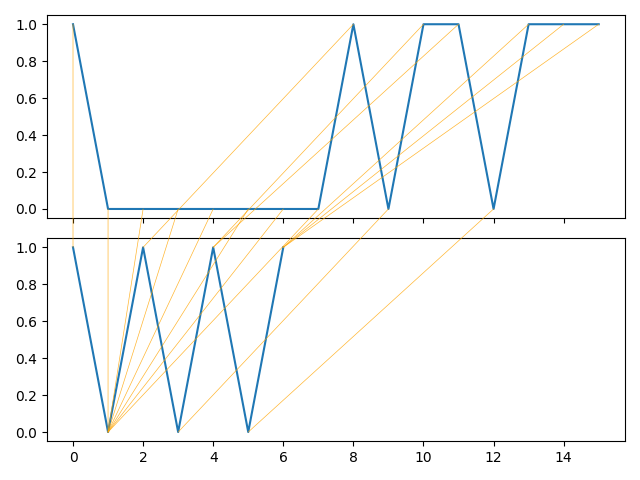

A better approach would be to compare the 2 lists directly, but account for `nyq_coef` by multiplying the freq of each coef by 2. Then check for inconsistencies, and how many there are. This way, it doesn't track the where the changes are, but how long is in between each one.

In [13]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import random
s1 = [1, 0, 0,0,0,0,0,0, 1, 0, 1,1, 0, 1, 1, 1]
print(s1)
s2 = [1,0,1,0,1,0,1]

# s1 = [0,0,1,1,0,0,0,0,1,1,0,0,1,1,1,1,1,1]
# s2 = [0,  1,  0,  0,  1,  0,  1,  1,  1]
path = dtw.warping_path(
    s1, s2
)
print(path)
dtwvis.plot_warping(s1,s2, path, filename="warp.png")
print(dtw.distance(s1,s2))

[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1]
[(0, 0), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 3), (10, 4), (11, 4), (12, 5), (13, 6), (14, 6), (15, 6)]
0.0


In [9]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

s2 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
s1 = [0,1,1,1,0,0,1,0,1,0,0]

path = dtw.warping_path(
    s1, s2
)
print(path)
dtwvis.plot_warping(s1,s2, path, filename="trial1.png")
print(dtw.distance(s1,s2))

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (2, 22), (3, 23), (4, 24), (4, 25), (4, 26), (5, 27), (6, 28), (6, 29), (7, 30), (7, 31), (7, 32), (8, 33), (8, 34), (9, 35), (9, 36), (9, 37), (9, 38), (9, 39), (9, 40), (9, 41), (9, 42), (9, 43), (9, 44), (9, 45), (9, 46), (9, 47), (9, 48), (9, 49), (9, 50), (9, 51), (9, 52), (10, 53)]
0.0
